In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action = 'ignore')
import io

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import roc_curve, RocCurveDisplay, roc_auc_score
from sklearn.metrics import plot_confusion_matrix, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline


from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.over_sampling import SMOTE

In [ ]:
url_1 = 'https://raw.githubusercontent.com/ariffinsarhid/Predicting-Airline-On-Time-Performance-In-Progress-/main/Data/final_table.csv'

df = pd.read_csv(url_1, index_col='flightdate')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 86761 entries, 11/06/19 to 09/02/18
Data columns (total 49 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   year                             86761 non-null  int64  
 1   quarter                          86761 non-null  int64  
 2   month                            86761 non-null  int64  
 3   dayofmonth                       86761 non-null  int64  
 4   dayofweek                        86761 non-null  int64  
 5   dot_id_reporting_airline         86761 non-null  int64  
 6   iata_code_reporting_airline      86761 non-null  object 
 7   flight_number_reporting_airline  86761 non-null  int64  
 8   originairportid                  86761 non-null  int64  
 9   originairportseqid               86761 non-null  int64  
 10  origincitymarketid               86761 non-null  int64  
 11  originstatefips                  86761 non-null  int64  
 12  originstatena

In [ ]:
df = pd.get_dummies(df, columns = ['iata_code_reporting_airline',
                                  'originstatename', 'deststatename', 'airline', 'origincity', 'destcity'])

In [ ]:
df.head()

,year,quarter,month,dayofmonth,dayofweek,dot_id_reporting_airline,flight_number_reporting_airline,originairportid,originairportseqid,origincitymarketid,originstatefips,originwac,destairportid,destairportseqid,destcitymarketid,destwac,crsdeptime,deptime,depdelay,depdelayminutes,depdel15,departuredelaygroups,taxiout,wheelsoff,wheelson,taxiin,crsarrtime,arrtime,arrdelay,arrdelayminutes,arrdel15,arrivaldelaygroups,crselapsedtime,actualelapsedtime,airtime,flights,distance,distancegroup,carrierdelay,weatherdelay,...,destcity_Spokane,destcity_Springfield,destcity_St. Cloud,destcity_St. George,destcity_St. Louis,destcity_St. Petersburg,destcity_State College,destcity_Staunton,destcity_Stillwater,destcity_Stockton,destcity_Sun Valley/Hailey/Ketchum,destcity_Syracuse,destcity_Tallahassee,destcity_Tampa,destcity_Texarkana,destcity_Toledo,destcity_Traverse City,destcity_Trenton,destcity_Tucson,destcity_Tulsa,destcity_Twin Falls,destcity_Tyler,destcity_Valdosta,destcity_Valparaiso,destcity_Vernal,destcity_Waco,destcity_Washington,destcity_Waterloo,destcity_Watertown,destcity_West Palm Beach/Palm Beach,destcity_West Yellowstone,destcity_White Plains,destcity_Wichita,destcity_Wichita Falls,destcity_Williston,destcity_Wilmington,destcity_Worcester,destcity_Wrangell,destcity_Yakutat,destcity_Yuma
flightdate,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11/06/19,2019,2,6,11,2,20363,3459,10397,1039707,30397,13,34,10868,1086803,30868,37,1950,2331.0,221.0,221.0,1.0,12.0,19.0,2350.0,25.0,6.0,2057,31.0,214.0,214.0,1.0,12.0,67.0,60.0,35.0,1,192,1,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10/04/18,2018,2,4,10,2,20363,5198,10397,1039707,30397,13,34,12197,1219702,31703,22,928,923.0,-5.0,0.0,0.0,-1.0,17.0,940.0,1119.0,4.0,1150,1123.0,-27.0,0.0,0.0,-2.0,142.0,120.0,99.0,1,780,4,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
01/10/19,2019,4,10,1,2,20363,3358,12953,1295304,31703,36,22,11057,1105703,31057,36,1910,2004.0,54.0,54.0,1.0,3.0,20.0,2024.0,2140.0,5.0,2130,2145.0,15.0,15.0,1.0,1.0,140.0,101.0,76.0,1,544,3,4.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27/07/18,2018,3,7,27,5,20363,5388,10821,1082106,30852,24,35,14492,1449202,34492,36,1526,1558.0,32.0,32.0,1.0,2.0,100.0,1738.0,1824.0,4.0,1636,1828.0,112.0,112.0,1.0,7.0,70.0,150.0,46.0,1,255,2,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
04/03/19,2019,1,3,4,1,20363,5179,14122,1412202,30198,42,23,12478,1247805,31703,22,604,631.0,27.0,27.0,1.0,1.0,34.0,705.0,808.0,7.0,745,815.0,30.0,30.0,1.0,2.0,101.0,104.0,63.0,1,340,2,0.0,27.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 86761 entries, 11/06/19 to 09/02/18
Columns: 868 entries, year to destcity_Yuma
dtypes: float64(22), int64(21), uint8(825)
memory usage: 97.4+ MB


## We will try to run our model using 10% of our dataset first. This is to get a first glimpse of how our model will work. 

In [ ]:
df1 = df.sample(frac=0.1, replace = False, random_state=42)
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8676 entries, 20/12/19 to 05/05/18
Columns: 868 entries, year to destcity_Yuma
dtypes: float64(22), int64(21), uint8(825)
memory usage: 9.7+ MB


### Preprocessing

In [ ]:
x = df1.drop(['arrdel15'],axis= 1)
y = df1.arrdel15

#train test split
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, random_state = 42)


print(x_train.shape, y_train.shape)

(6507, 867) (6507,)


## Check the baseline score

In [ ]:
y.value_counts()  

0.0    7050
1.0    1626
Name: arrdel15, dtype: int64

In [ ]:
y.shape

(8676,)

In [ ]:
def score(model,x_train, x_test):
    
    """
    This function scores the model by returning the confusion matrix and classification report of the model
    
    """
    
    # Get predictions
    preds = model.predict(x_test)
    cm = confusion_matrix(y_test, preds)
    ConfusionMatrixDisplay(cm, display_labels=['Flight Not Delay','Flight Delay']).plot(cmap='GnBu')

    print("Training Score:",model.score(x_train,y_train))
    print("Testing Score:",model.score(x_test,y_test))
    print("\n")
    print(classification_report(y_test, preds)) 


In [ ]:
def fimportance_df(list_of_features,list_of_feature_scores):
    
    """
    This function returns a dataframe, ranking the top features as the top rows.
    
    """
    abs_list = [abs(i) for i in list_of_feature_scores]
    fimportance = zip(list_of_features, list_of_feature_scores, abs_list)
    df = pd.DataFrame(fimportance,columns=['Feature','Feature_Significance','Feature_Significance_Abs'])
    df = df.sort_values("Feature_Significance_Abs",ascending=False).reset_index(drop=True)
    return df[['Feature','Feature_Significance']]

In [ ]:
def fimportance(list_of_features, list_of_feature_scores):

    """
    This function plots the feature importance/coefficients as horizontal bar plot.
    
    It takes in dataframe generated from the fimportance_df function.
    
    """    
    
    # Initialize the matplotlib figure
    df=fimportance_df(list_of_features, list_of_feature_scores)
    
    with sns.axes_style("whitegrid"):
        f, ax = plt.subplots(figsize=(8, 12))
        
        # Plot the features
        sns.set_color_codes("muted")
        hbar = sns.barplot(x="Feature_Significance",
                            y="Feature",
                            data=df,
                            color="b")
        for bar in hbar.patches:
   
        # Using Matplotlib's annotate function and
        # passing the coordinates where the annotation shall be done
        # x-coordinate: bar.get_width()
        # y-coordinate: bar.get_y()+bar.get_height()/2
        # free space to be left to make graph pleasing: (0, 0)
        # ha and va stand for the horizontal and vertical alignment
            hbar.annotate(format(bar.get_width(), '.3f'), # text is width of bar
                      (bar.get_width(), bar.get_y()+bar.get_height()/2), # coordinates of each annotation
                      ha='left', va='center',
                       size=10, xytext=(2, 0),
                       textcoords='offset points')
          # Add axis label
    ax.set(title= "Feature Significance",
           xlabel="Score",
          ylabel="Feature")
    ax.xaxis.get_label().set_fontsize(20)
    ax.yaxis.get_label().set_fontsize(20)
    ax.title.set_fontsize(30)
    sns.despine(left=True, bottom=True)


In [ ]:
def roc(model, model_name, X_train, X_test): 
    
    """
    This function generates the ROC/AUC curve of the model.
    
    Due to the imbalanced nature of the data, the preferred metrics for this project is ROC/AUC.
    
    """      
    
    plt.figure(figsize=(16,10))
    
    # Predict probabilities from X_test
    df = pd.DataFrame(model.predict_proba(X_test))
    preds = df.drop(columns=0)
    
    # 
    fpr, tpr, _ = roc_curve(y_test, preds)
    auc = roc_auc_score(y_test, preds)

    df2 = pd.DataFrame(model.predict_proba(X_train))
    preds2 = df2.drop(columns=0)
    fpr2, tpr2, _ = roc_curve(y_train, preds2)
    auc2 = roc_auc_score(y_train, preds2)
    
    with sns.axes_style(style="darkgrid"):
        plt.plot(fpr,tpr,color='orange',label="%s test, auc=%s" %(model_name, format(auc,".3f")))
        plt.plot(fpr2,tpr2,color='blue',label="%s train, auc=%s" %(model_name, format(auc2,".3f")))
        plt.plot(y_test,y_test,color='gray',linestyle=':') #baseline 50%
    plt.legend(loc='lower right')    
    
    sns.despine(left=True,bottom=True)

In [ ]:
preprocess_pipe = make_pipeline(MinMaxScaler())

In [ ]:
# preprocess data through pipeline for modelling

x_train_t = preprocess_pipe.fit_transform(x_train)
x_test_t = preprocess_pipe.transform(x_test)

In [ ]:
#create pipeline
lr_pipe = make_pipeline(SMOTE(random_state = 42), 
                        LogisticRegression(max_iter=200, random_state = 42)
                       )
    

# define grid params for logistic regression
lr_params = {
    'logisticregression__C': [0.02, 0.05, 0.1],
    'logisticregression__solver' : ['newton-cg','saga', 'sag', 'lbfgs'],
    'logisticregression__multi_class': ['multinomial', 'ovr', 'auto'],
    'logisticregression__penalty':['l1','l2','elasticnet'],
    'logisticregression__l1_ratio':[None, 0.25,0.5,0.75],
    'logisticregression__class_weight':[None, 'balanced']
}
    

# Instantiate GridSearchCV
# Due to imbalanced data, scoring = roc & auc
grid_lr = GridSearchCV(lr_pipe, param_grid = lr_params, verbose = 1, n_jobs=-1, cv=3, scoring='roc_auc')

In [ ]:
# preprocess data through pipeline for modelling

x_train_t = preprocess_pipe.fit_transform(x_train)
x_test_t = preprocess_pipe.transform(x_test)

In [ ]:
grid_lr.fit(x_train_t,y_train)

Fitting 3 folds for each of 864 candidates, totalling 2592 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=200,
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [0.02, 0.05, 0.1],
                         'logisticregression__class_weight': [None, 'balanced'],
                         'logisticregression__l1_ratio': [None, 0.25, 0.5,
                                                          0.75],
                         'logisticregression__multi_class': ['multinomial',
                                                             'ovr', 'auto'],
                         'logisticregression__penalty': ['l1', 'l2',
                                                         'elasticnet'],
                         'logisticregression__solver': ['newton-cg', 'saga',
       

In [ ]:
print("best score", grid_lr.best_score_)
print("best params", grid_lr.best_params_)

best score 1.0
best params {'logisticregression__C': 0.05, 'logisticregression__class_weight': None, 'logisticregression__l1_ratio': None, 'logisticregression__multi_class': 'multinomial', 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'saga'}


Training Score: 1.0
Testing Score: 1.0


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1763
         1.0       1.00      1.00      1.00       406

    accuracy                           1.00      2169
   macro avg       1.00      1.00      1.00      2169
weighted avg       1.00      1.00      1.00      2169



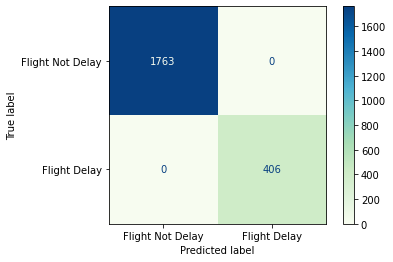

In [ ]:
score(grid_lr, x_train_t, x_test_t)

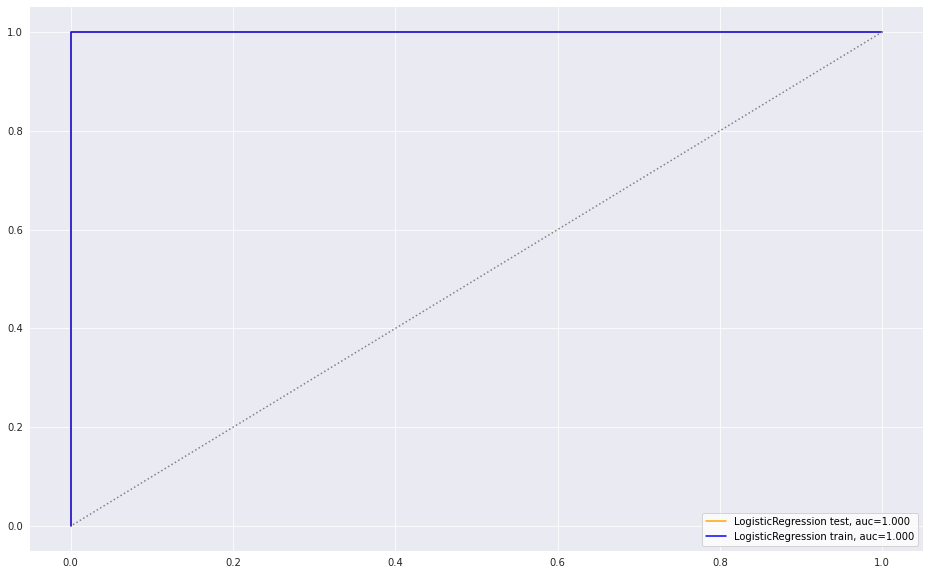

In [ ]:
roc(grid_lr,"LogisticRegression", x_train_t, x_test_t)

##